In [354]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log

In [334]:
main_folder = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/"
ATTR_PATH = main_folder + "list_attr_celeba.csv"  
PARTITION_PATH = main_folder + "list_eval_partition.csv" 
IMAGES_PATH = main_folder + "img_align_celeba/img_align_celeba/"  
MODEL_HANDLE = "./model" 
IMAGE_SIZE = (220, 220)

#Performance
BATCH_SIZE = 128
TRAIN_SAMPLE = 5000
VALIDATION_SAMPLE = 1000
NUM_EPOCHS = 5

In [360]:
def select_best_features():
    df1 = pd.read_csv(ATTR_PATH, delimiter=',')
    df1.dataframeName = 'list_attr_celeba.csv'
    scores=[]
    for column in df1:
        if column != 'image_id':
            a = len(df1[df1[column] == 1])
            b = len(df1[df1[column] == -1])
            score = abs(a-b)/(a+b)
            scores.append((column,1/score))
    scores.sort(reverse = True)
    scores.sort(key=lambda a: a[1])
    scores.reverse()
    N=22
    scores_subset = [x for index, x in enumerate(scores) if index < N]
    selected_features = [scores_subset[i][0] for i in range(len(scores_subset))]
    
    #Manual tweaking
    selected_features.remove('Attractive')
    return selected_features

select_best_features()

['Mouth_Slightly_Open',
 'Smiling',
 'Wearing_Lipstick',
 'High_Cheekbones',
 'Male',
 'Heavy_Makeup',
 'Wavy_Hair',
 'Oval_Face',
 'Pointy_Nose',
 'Arched_Eyebrows',
 'Big_Lips',
 'Black_Hair',
 'Big_Nose',
 'Young',
 'Straight_Hair',
 'Brown_Hair',
 'Bags_Under_Eyes',
 'Wearing_Earrings',
 'No_Beard',
 'Bangs',
 'Blond_Hair']

In [353]:
df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()
for column in df:
    print(column)
Bangs
Big_Lips
Big_Nose
features_str = ['Bald','Blond_Hair','Male','No_Beard','Smiling','Wearing_Lipstick','Young']    
#features_str = ['Bald','Black_Hair','Blond_Hair','Brown_Hair','Chubby','Male','Mouth_Slightly_Open','Mustache','No_Beard','Pale_Skin','Wearing_Lipstick','Young']    

image_id
partition
5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [336]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, Bald,Blond_Hair,Male,No_Beard,Smiling,Wearing_Lipstick,Young):
    images = load_and_preprocess_image(path)
    return images, Bald,Blond_Hair,Male,No_Beard,Smiling,Wearing_Lipstick,Young

def init_dataset(df):
    a = ([IMAGES_PATH + image_id for image_id in df["image_id"]],)
    for feature in features_str:
        b =  list(df[feature].replace(-1,0))
        a = a + (b,)
    return a


def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices(init_dataset(df))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [337]:
train_df = df.loc[df["partition"] == 0].head(TRAIN_SAMPLE)
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1].head(VALIDATION_SAMPLE)
val_ds = build_dataset_from_df(val_df)

#val_df

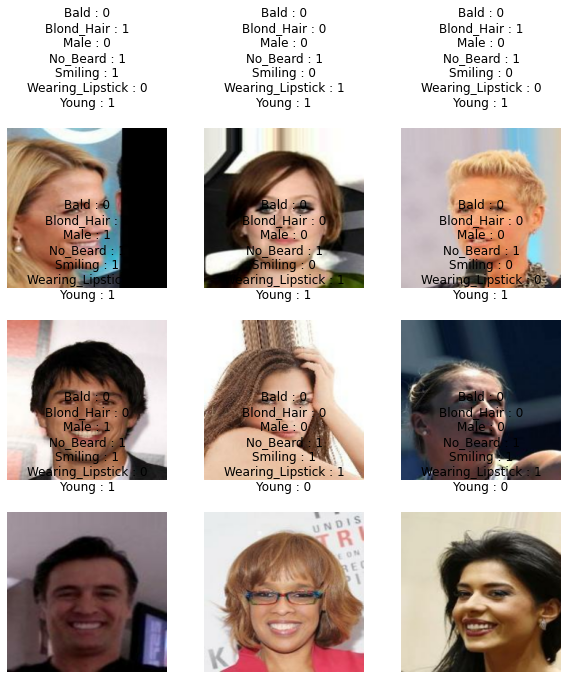

In [338]:
image, Bald, Blond_Hair, Male, No_Beard, Smiling, Wearing_Lipstick, Young = next(iter(train_ds))
features = [Bald, Blond_Hair, Male, No_Beard, Smiling, Wearing_Lipstick, Young]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = ""
    for j in range(len(features)):
        s+= str(features_str[j]) +" : "
        s+= str(features[j][i].numpy())
        s+= '\n'
    plt.title(s)
    plt.axis("off")

In [339]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, Bald, Blond_Hair, Male, No_Beard, Smiling, Wearing_Lipstick, Young:
                        (preprocessing_model(images), (Bald, Blond_Hair, Male, No_Beard, Smiling, Wearing_Lipstick, Young)))

val_ds = val_ds.map(lambda images, Bald, Blond_Hair, Male, No_Beard, Smiling, Wearing_Lipstick, Young:
                    (normalization_layer(images), (Bald, Blond_Hair, Male, No_Beard, Smiling, Wearing_Lipstick, Young)))

In [352]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

outs = []

for feature in features_str:
    out = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name=feature)(x)
    outs.append(out)


model = tf.keras.Model( inputs = input, outputs = outs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer_7 (KerasLayer)     (None, 1280)         5919312     ['input_8[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, 1280)         0           ['keras_layer_7[0][0]']          
                                                                                                  
 dense_7 (Dense)                (None, 128)          163968      ['dropout_7[0][0]']        

In [341]:
model.compile(
    loss = {
        "Bald": tf.keras.losses.BinaryCrossentropy(),
        "Blond_Hair": tf.keras.losses.BinaryCrossentropy(),
        "Male": tf.keras.losses.BinaryCrossentropy(),
        "No_Beard": tf.keras.losses.BinaryCrossentropy(),
        "Smiling": tf.keras.losses.BinaryCrossentropy(),
        "Wearing_Lipstick": tf.keras.losses.BinaryCrossentropy(),
        "Young": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "Bald": 'accuracy',
        "Blond_Hair": 'accuracy',
        "Male": 'accuracy',
        "No_Beard": 'accuracy',
        "Smiling": 'accuracy',
        "Wearing_Lipstick": 'accuracy',
        "Young": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [342]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
39/39 [==============================] - 301s 8s/step - loss: 2.5299 - Bald_loss: 0.1412 - Blond_Hair_loss: 0.2819 - Male_loss: 0.2504 - No_Beard_loss: 0.3855 - Smiling_loss: 0.6263 - Wearing_Lipstick_loss: 0.3623 - Young_loss: 0.4809 - Bald_accuracy: 0.9541 - Blond_Hair_accuracy: 0.8872 - Male_accuracy: 0.8940 - No_Beard_accuracy: 0.8197 - Smiling_accuracy: 0.6486 - Wearing_Lipstick_accuracy: 0.8323 - Young_accuracy: 0.7883 - val_loss: 1.8360 - val_Bald_loss: 0.0691 - val_Blond_Hair_loss: 0.1864 - val_Male_loss: 0.1358 - val_No_Beard_loss: 0.2483 - val_Smiling_loss: 0.5419 - val_Wearing_Lipstick_loss: 0.2594 - val_Young_loss: 0.3936 - val_Bald_accuracy: 0.9788 - val_Blond_Hair_accuracy: 0.9286 - val_Male_accuracy: 0.9509 - val_No_Beard_accuracy: 0.8761 - val_Smiling_accuracy: 0.7388 - val_Wearing_Lipstick_accuracy: 0.8917 - val_Young_accuracy: 0.8460
Epoch 2/5
39/39 [==============================] - 298s 8s/step - loss: 1.7100 - Bald_loss: 0.0611 - Blond_Hair_loss: 0.1805 -

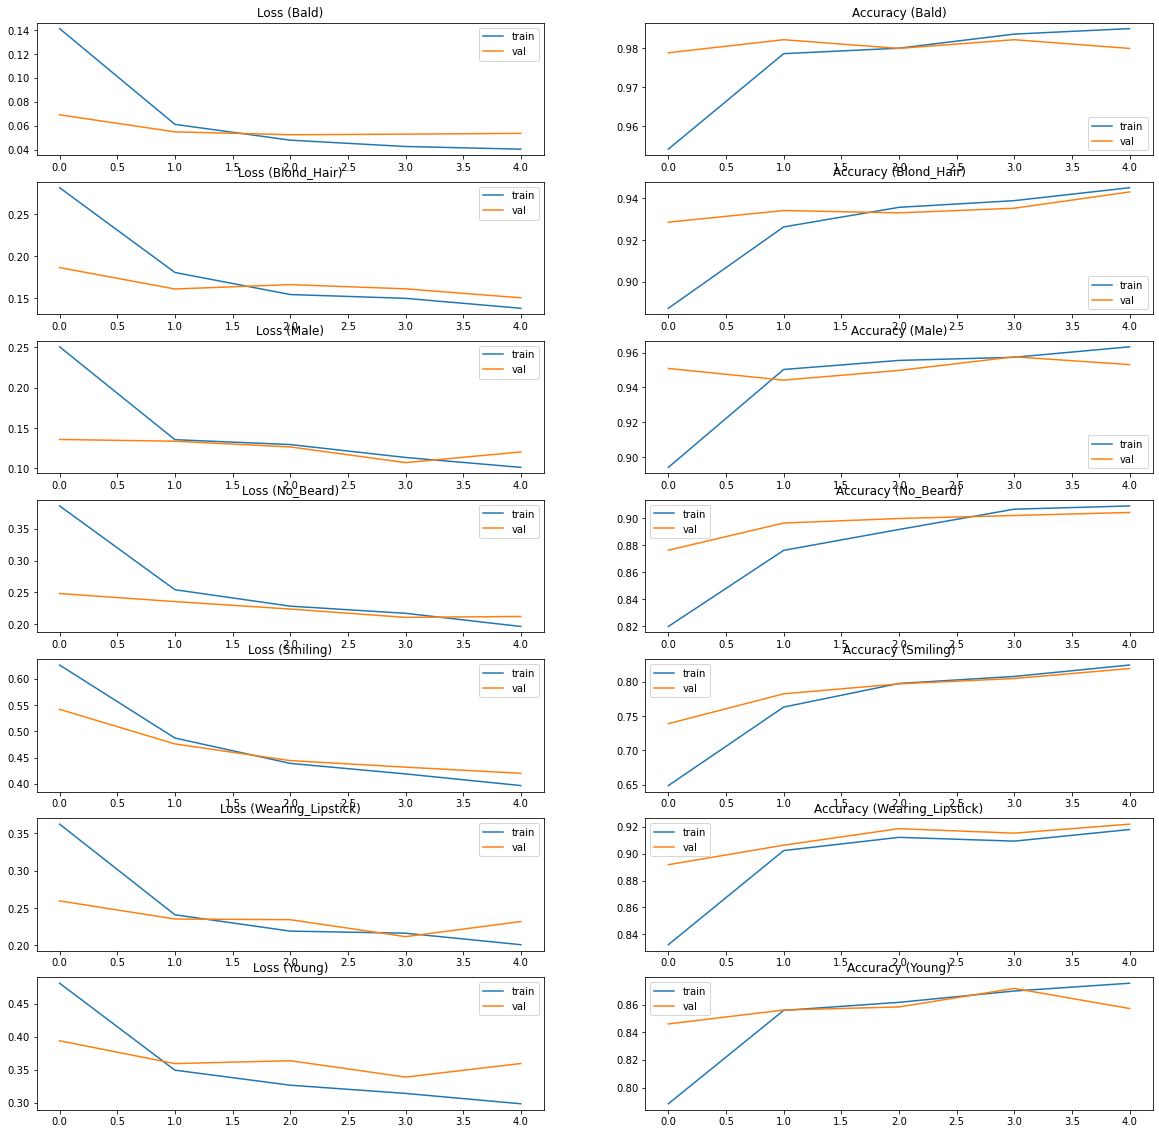

In [343]:
fig, ax = plt.subplots(len(features_str), 2, figsize=(20, 20))
for i, c in enumerate(features_str):
    ax[i, 0].plot(hist[f"{c}_loss"], label="train")
    ax[i, 0].plot(hist[f"val_{c}_loss"], label="val")
    ax[i, 0].set_title(f"Loss ({c})")
    ax[i, 0].legend()
    ax[i, 1].plot(hist[f"{c}_accuracy"], label="train")
    ax[i, 1].plot(hist[f"val_{c}_accuracy"], label="val")
    ax[i, 1].set_title(f"Accuracy ({c})")
    ax[i, 1].legend()
plt.show()

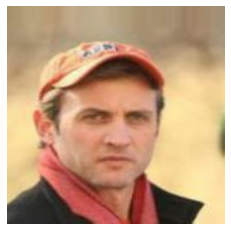

(<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>, <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])>, <tf.Tensor: shape=(128,), dtype=int32, numpy=
arr

In [351]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()
#print(x)

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(features_str):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

In [345]:
def open_images(inference_folder: str) -> np.ndarray:
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  
        with Image.open(img_location) as img:  
            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  
        images.append(img)
    images_array = np.vstack(images) 
    return images_array

In [346]:
from PIL import Image
import os, sys

path = "./image_samples/"
dirs = os.listdir( path )
resized_path = "./images_resized/"

def resize():
    for item in dirs:
        print(item)
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            im = im.convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((220,220), Image.ANTIALIAS)
            imResize.save(resized_path + item + '_resized.jpg', 'JPEG', quality=90)

resize()

162771.jpg
321116120_613149164144508_8497526687511687835_n.jpg
321240135_698995238546479_983226794941031556_n.jpg
321524186_733681281318622_8413083612589801687_n.jpg
321553608_529503195799433_8824502125631363198_n.jpg
321583445_1566567133787809_2598837799567296422_n.jpg
321717131_5845034862248080_5614988834469057400_n.jpg
321978282_2789787894485100_6684771661562603172_n.jpg
321979583_1268521123877266_170285861591344890_n.jpg
322307120_664010718751666_8540839711723716088_n.jpg
322595586_709744033848953_3270901739627174524_n.jpg
celia.jpg
jean.jpg
nada.jpg
rostom.jpg
salma.jpg
souhail.jpg
wissem.jpg
yasser.jpg


In [347]:
def display_image(image,s):
    plt.imshow(image)
    plt.title(s)
    plt.figure()

In [348]:
def image_prediction(prediction_score):
    s = ""
    for i, label in enumerate(features_str):
        pred = prediction_score[i][0][0]
        s += f"{label}: predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})"
        s +="\n"
    return s  

1/1 [==============================] - 0s 360ms/step


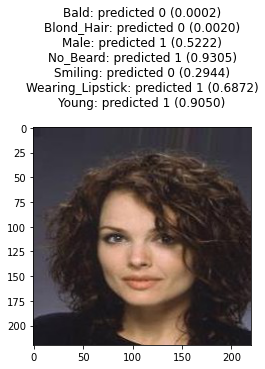

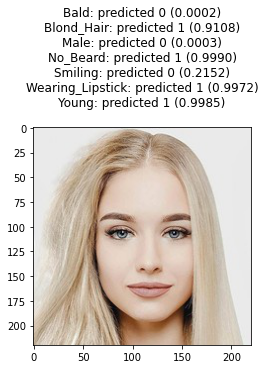

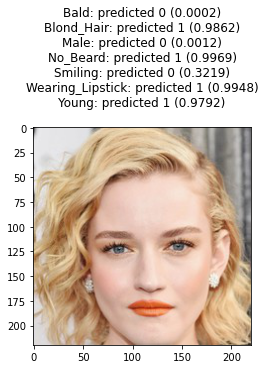

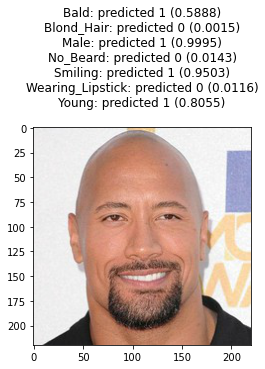

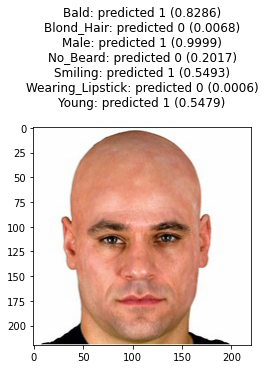

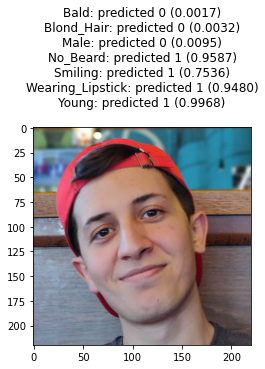

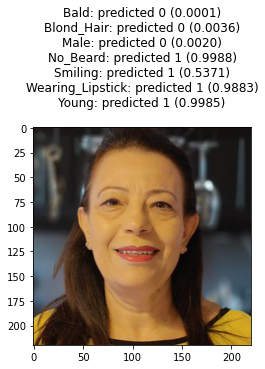

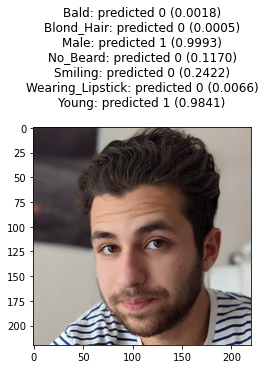

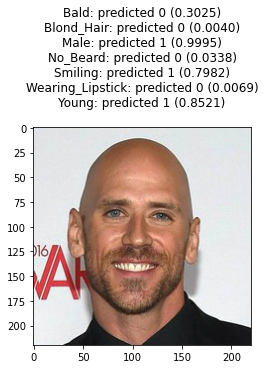

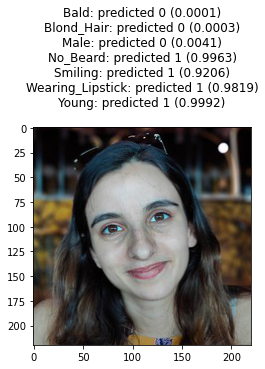

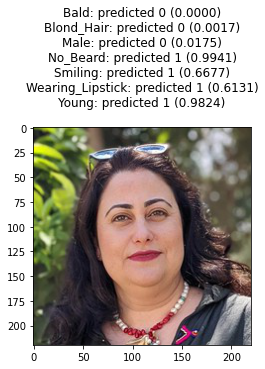

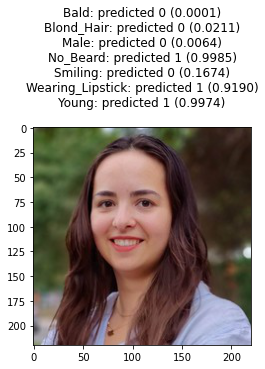

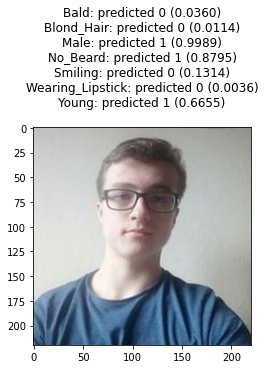

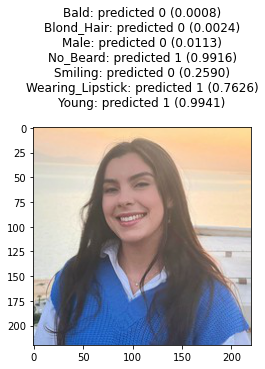

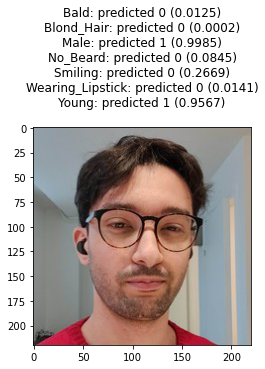

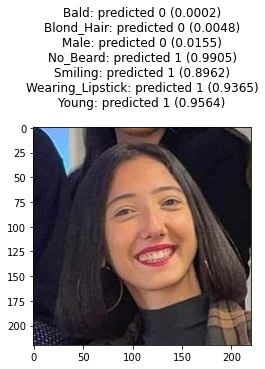

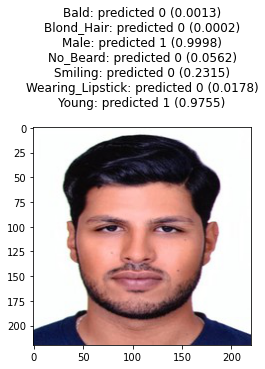

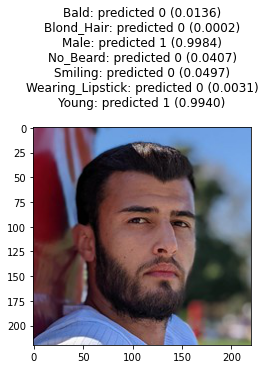

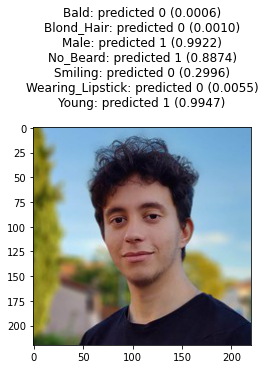

<Figure size 432x288 with 0 Axes>

In [349]:
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
images = open_images(resized_path)
c=0
for image in images:
    #img_batch = np.expand_dims(image * 10e-4, axis=0)
    img_batch = np.expand_dims(image, axis=0)
    #print(img_batch)
    normalizedData = (img_batch-np.min(img_batch))/(np.max(img_batch)-np.min(img_batch))
    #print(normalizedData)
    prediction_score= model.predict(normalizedData)
    s = image_prediction(prediction_score)
    display_image(image,s)